In [553]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from numpy import linalg as LA

# see all columns at once with scrolling
pd.set_option('display.max_columns', 0)
plt.figure()
plt.rcParams.update({'font.size': 10}) # must set in top

<Figure size 432x288 with 0 Axes>

In [554]:
owid = pd.read_csv('1_owid/owid-covid-data.csv')
eu_response = pd.read_csv('2_ecdc/country_response_measures.csv')

# df is the final dataset to use
df = owid[["location","date","reproduction_rate"]]

In [555]:
# only keep rows in df that match to a country in eu_response
df = df[[x in eu_response["Country"].unique() for x in df["location"]]]
df.dropna(inplace=True)

In [556]:
# adding a column of all ones for beta_avg
try:
    df.insert(len(df.columns), "beta_avg", 1)
except ValueError:  # ValueError thrown if df already has that column
    pass

# initialize a column for each country type with all 0s
for country in eu_response["Country"].unique():
    try:
        df.insert(len(df.columns), country, 0)
    except ValueError:  # ValueError thrown if df already has that column
        pass
# set the corresponding country to 1
for _, row in df.iterrows():
    df.loc[ df["location"] == row["location"] , row["location"]] = 1


# initialize a column for each response type with all 0s
for response in eu_response["Response_measure"].unique():
    try:
        df.insert(len(df.columns), response, 0)
    except ValueError:  # ValueError thrown if df already has that column
        pass
for _, row in eu_response.iterrows():
    df.loc[ ( df["location"] == row["Country"] ) & ( df["date"] >= row["date_start"] ) & ( df["date"] < row["date_end"] ), row["Response_measure"]] = 1

In [557]:
# prepare data and divide train & test set
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [558]:
# for given (tau, alpha), return the testing score
def LASSO_alpha_tau(para):
    tau = para[:,0]
    alp = para[:,1]
    # Data processing: shift by tau
    df_copy = df.copy()
    df_copy[eu_response["Response_measure"].unique()] = df_copy.groupby("location")[eu_response["Response_measure"].unique()].shift(tau).fillna(0)
    
    # Split training and testing data
    train, test = train_test_split(df_copy, test_size=0.1)
    idx_data = ["beta_avg"] + list( eu_response["Country"].unique() ) + list( eu_response["Response_measure"].unique())
    idx_target = "reproduction_rate"
    Xtrain = train[idx_data]
    Ytrain = train[idx_target]   
    Xtest = test[idx_data]
    Ytest = test[idx_target]
    
    # LASSO
    N_s = Xtrain.shape[0]
    clf = linear_model.Lasso(alpha=alp / (2*N_s) )
    clf.fit(Xtrain, Ytrain)
    
    # return testing score
    # score = clf.score(Xtest, Ytest)
    err = LA.norm( Ytest - clf.predict(Xtest) )**2 / Ytest.shape[0]
    return err, clf



In [298]:
!pip install GPyOpt
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [559]:
bounds2d = [{'name': 'tau', 'type': 'discrete', 'domain': tuple(np.arange(60))},
            {'name': 'alpha', 'type': 'discrete', 'domain': (1e-5, 5)}]

maxiter = 200


Value of (x,y) that minimises the objective:[3.5e+01 1.0e-05]
Minimum value of the objective: 0.07860910196354777


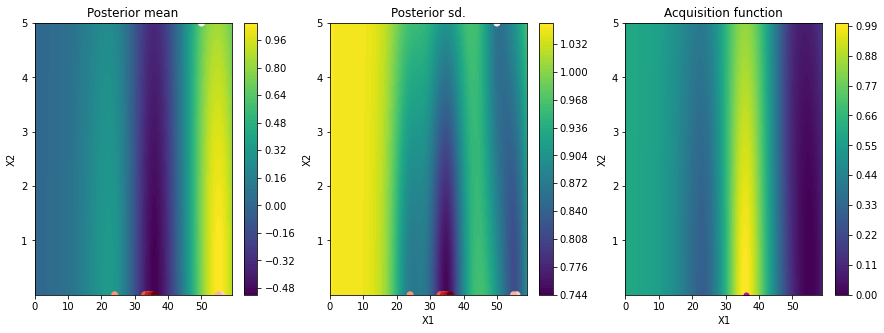

In [560]:
def objective(x):
    out, _ = LASSO_alpha_tau(x)
    return out
    

myBopt_2d = GPyOpt.methods.BayesianOptimization(objective, 
                                                domain=bounds2d, 
                                                acquisition_type = "MPI")
myBopt_2d.run_optimization(max_iter = maxiter)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(myBopt_2d.x_opt))    
print("Minimum value of the objective: "+str(myBopt_2d.fx_opt))     
print("="*20)
myBopt_2d.plot_acquisition()


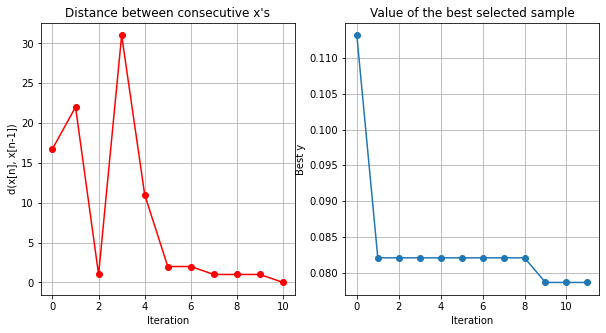

In [562]:
myBopt_2d.plot_convergence()

In [563]:
tau_star = myBopt_2d.x_opt[0]
alpha_star = myBopt_2d.x_opt[1]

print([tau_star, alpha_star])

err, lasso_star = LASSO_alpha_tau(np.array([[tau_star, alpha_star]]))
err

[35.0, 1e-05]


0.10256557163919285

Text(0.5, 1.0, 'Effectiveness ranking of response measures via LASSO')

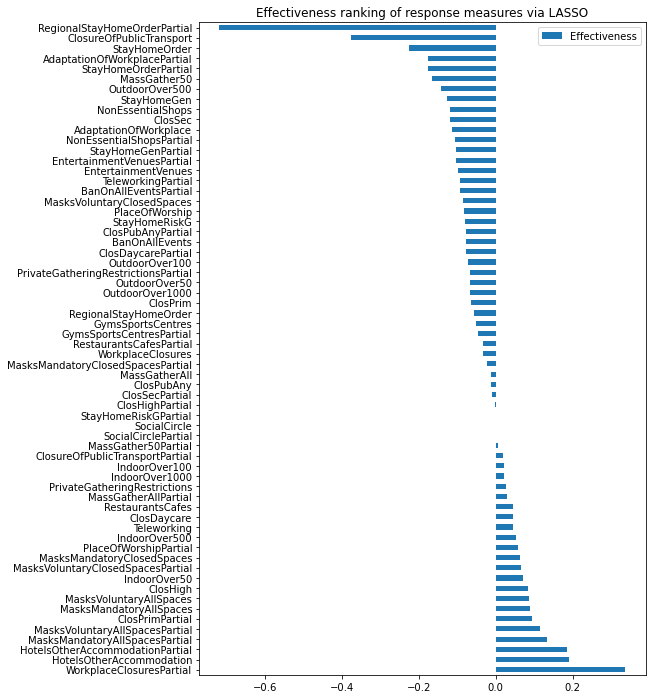

In [565]:
# given the weights from LASSO model, rank the response measures
beta_star = lasso_star.coef_
N = len(beta_star)
N_r = 64
beta_r = beta_star[N - N_r :]
pd.DataFrame(data = beta_r, index = eu_response["Response_measure"].unique(), columns = ['Effectiveness']).sort_values(by = 'Effectiveness', ascending=False).plot.barh(figsize=(8,12))
plt.title("Effectiveness ranking of response measures via LASSO")

<AxesSubplot:xlabel='tau'>

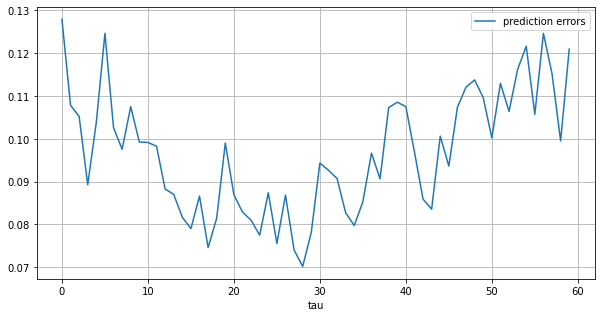

In [566]:
# grid search
TAU_RANGE = 60
test_score = []
for i in range(0,TAU_RANGE):    
    test_score = test_score + [LASSO_alpha_tau(np.array([[i, 1e-3]]))[0]]
score_by_tau = pd.DataFrame({'tau':range(0,TAU_RANGE),'prediction errors':test_score})
score_by_tau.set_index('tau').plot(figsize=(10,5), grid=True)

In [567]:
# different tau for each response measures
# delay of effectiveness for each response measures
# for given (tau, alpha), return the testing score
def LASSO_alpha_tau_responses(para):
    # Data processing: shift by tau_r for each response measure 
    df_copy = df.copy()
    
    responses_list = eu_response["Response_measure"].unique()
    N_r = len(responses_list)
    
    tau_vec = para[:,:N_r]
    alp = para[:,N_r]
    
    for i in range(N_r):
        res = responses_list[i]
        tau = tau_vec[:, i]
    df_copy[res] = df_copy.groupby("location")[res].shift(tau).fillna(0)
    
    # Split training and testing data
    train, test = train_test_split(df_copy, test_size=0.1)
    idx_data = ["beta_avg"] + list( eu_response["Country"].unique() ) + list( responses_list )
    idx_target = "reproduction_rate"
    Xtrain = train[idx_data]
    Ytrain = train[idx_target]   
    Xtest = test[idx_data]
    Ytest = test[idx_target]
    
    # LASSO
    N_s = Xtrain.shape[0]
    clf = linear_model.Lasso(alpha=alp / (2*N_s) )
    clf.fit(Xtrain, Ytrain)
    
    # return testing score
    # score = clf.score(Xtest, Ytest)
    err = LA.norm( Ytest - clf.predict(Xtest) )**2 / Ytest.shape[0]
    return err, clf


In [380]:
# Bayesian Optimization
N_r = 64
TAU_MAX = 60
bounds = []
for i in range(N_r): 
    bounds = bounds + [{'name': 'tau'+str(i), 'type': 'discrete', 'domain': tuple(np.arange(TAU_MAX))}]
bounds = bounds + [{'name': 'alpha', 'type': 'discrete', 'domain': (1e-5, 5)}]

maxiter = 200

def objective_response(x):
    out, _ = LASSO_alpha_tau_responses(x)
    return out
    

opt_response_delay = GPyOpt.methods.BayesianOptimization(objective_response, 
                                                domain=bounds, 
                                                acquisition_type = "MPI")
opt_response_delay.run_optimization(max_iter = maxiter)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(opt_response_delay.x_opt))    
print("Minimum value of the objective: "+str(opt_response_delay.fx_opt))     
print("="*20)

Value of (x,y) that minimises the objective:[3.0e+00 1.2e+01 4.1e+01 3.7e+01 5.6e+01 5.2e+01 5.2e+01 4.8e+01 7.0e+00
 3.3e+01 5.5e+01 2.9e+01 3.6e+01 2.4e+01 4.0e+00 9.0e+00 3.2e+01 4.3e+01
 2.0e+01 4.6e+01 4.5e+01 2.5e+01 2.0e+01 3.9e+01 3.9e+01 1.8e+01 3.7e+01
 5.6e+01 3.5e+01 5.3e+01 1.8e+01 1.6e+01 5.7e+01 4.0e+01 4.0e+00 5.1e+01
 1.6e+01 3.8e+01 4.1e+01 5.7e+01 5.0e+01 3.8e+01 4.6e+01 9.0e+00 5.6e+01
 5.6e+01 3.6e+01 5.9e+01 3.0e+00 2.0e+00 4.3e+01 5.7e+01 1.5e+01 1.8e+01
 1.7e+01 3.3e+01 4.9e+01 3.0e+00 4.4e+01 5.0e+01 4.7e+01 3.3e+01 5.3e+01
 1.5e+01 1.0e-05]
Minimum value of the objective: 0.08655853720082447


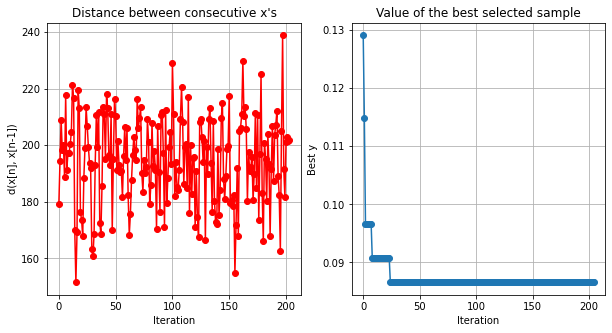

In [568]:
opt_response_delay.plot_convergence()

Text(0.5, 1.0, 'Time-delays ranking of response measures via LASSO')

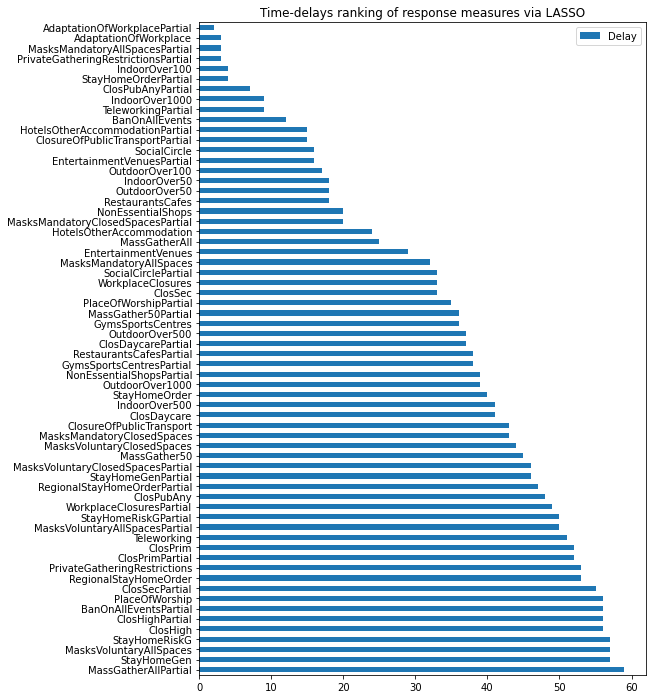

In [570]:
# given the weights from LASSO model, rank the response measures
N_r = 64
tau_r = opt_response_delay.x_opt[:N_r]
pd.DataFrame(data = tau_r, index = eu_response["Response_measure"].unique(), columns = ['Delay']).sort_values(by = 'Delay', ascending=False).plot.barh(figsize=(8,12))
plt.title("Time-delays ranking of response measures via LASSO")

Text(0.5, 1.0, 'Effectiveness ranking of response measures via LASSO')

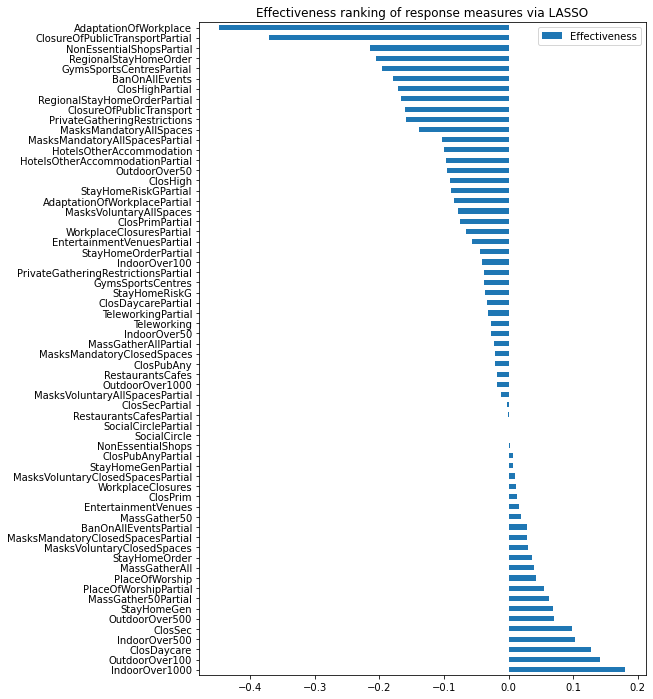

In [571]:
err, model = LASSO_alpha_tau_responses(np.array([opt_response_delay.x_opt]))
# given the weights from LASSO model, rank the response measures
beta_star = model.coef_
N = len(beta_star)
N_r = 64
beta_r = beta_star[N - N_r :]
pd.DataFrame(data = beta_r, index = eu_response["Response_measure"].unique(), columns = ['Effectiveness']).sort_values(by = 'Effectiveness', ascending=False).plot.barh(figsize=(8,12))
plt.title("Effectiveness ranking of response measures via LASSO")

In [572]:
responses_eff_delay = pd.DataFrame(data = beta_r, index = eu_response["Response_measure"].unique(), columns = ['beta'])
responses_eff_delay.insert(1, "delay", tau_r)
responses_eff_delay


,beta,delay
AdaptationOfWorkplace,-0.447214,3.0
BanOnAllEvents,-0.178463,12.0
ClosDaycare,0.128352,41.0
ClosDaycarePartial,-0.033445,37.0
ClosHigh,-0.091256,56.0
...,...,...
StayHomeRiskGPartial,-0.088661,50.0
RegionalStayHomeOrderPartial,-0.165951,47.0
SocialCirclePartial,0.000000,33.0
RegionalStayHomeOrder,-0.205406,53.0


Text(0.5, 0, 'beta')


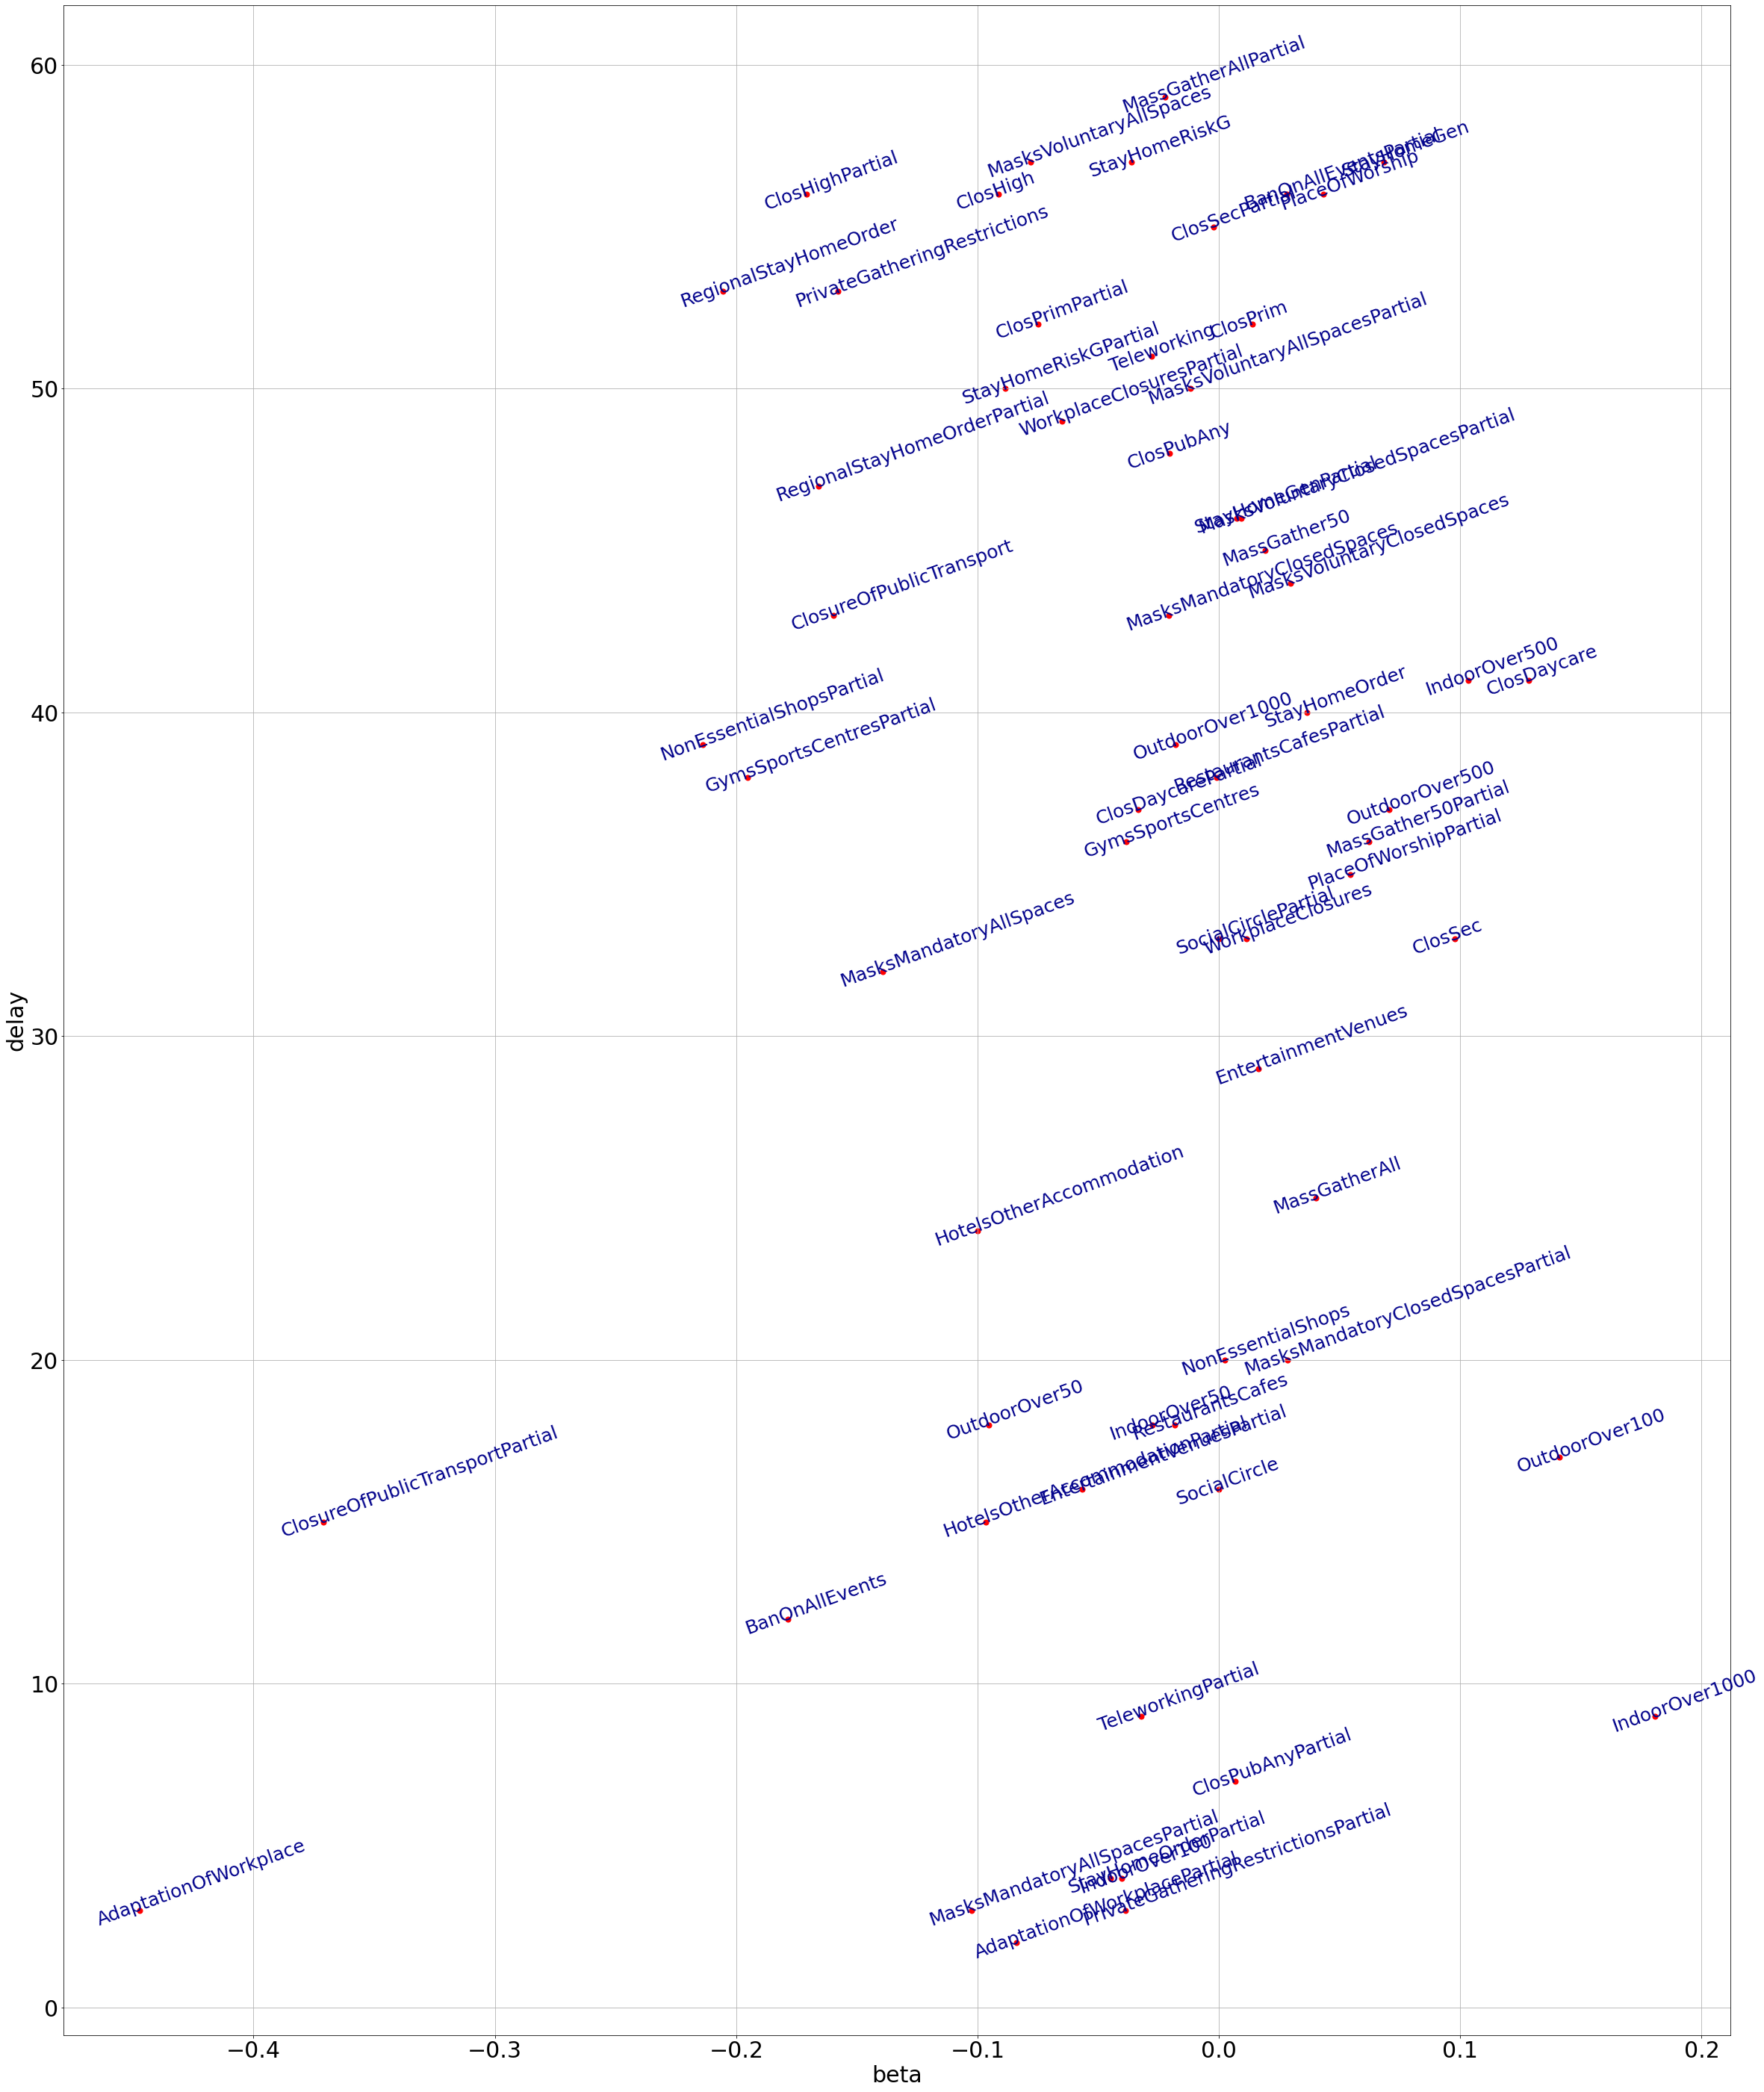

In [584]:
fig1, ax1 = plt.subplots()
responses_eff_delay.plot('beta', 'delay', 
                         kind='scatter', 
                         ax=ax1,  
                         figsize=(40,50),
                         c='red',
                         s= 50,
                         colormap='viridis',
                         grid=True)
for beta, tau in responses_eff_delay.iterrows():
    ax1.annotate(beta, tau, 
                xytext= (-60,-20), 
                textcoords='offset points',
                family='sans-serif', 
                fontsize=25, 
                color='DarkBlue',
                rotation= 20)

for item in ([ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(30)
print(ax1.xaxis.label) 